<a href="https://colab.research.google.com/github/kloiks/github-slideshow/blob/main/BigDataProject(PySpark).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("heart_disease_classification").getOrCreate()

#Reading data from csv and creating a Spark Dataframe
df = spark.read.csv("/content/drive/Shareddrives/CSP 554/heart_2020_cleaned.csv", inferSchema=True, header=True)
df.show(5)

+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|   Sex|AgeCategory| Race|Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|
+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|          No| 16.6|    Yes|             No|    No|           3.0|        30.0|         No|Female|      55-59|White|     Yes|             Yes|Very good|      5.0|   Yes|           No|       Yes|
|          No|20.34|     No|             No|   Yes|           0.0|         0.0|         No|Female|80 or older|White|      No|             Yes|Very good|      7.0|    No|           No|        No|
|          No|26.58|    Y

In [ ]:
df.printSchema()

root
 |-- HeartDisease: string (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- AlcoholDrinking: string (nullable = true)
 |-- Stroke: string (nullable = true)
 |-- PhysicalHealth: double (nullable = true)
 |-- MentalHealth: double (nullable = true)
 |-- DiffWalking: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeCategory: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Diabetic: string (nullable = true)
 |-- PhysicalActivity: string (nullable = true)
 |-- GenHealth: string (nullable = true)
 |-- SleepTime: double (nullable = true)
 |-- Asthma: string (nullable = true)
 |-- KidneyDisease: string (nullable = true)
 |-- SkinCancer: string (nullable = true)



In [ ]:
label = 'HeartDisease'
numerical_cols = ['BMI', 'PhysicalHealth','MentalHealth','SleepTime']
categorical_cols = list(set(df.columns) - set(numerical_cols) -set([label]))

In [ ]:
df.select(numerical_cols).describe().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|               BMI|    PhysicalHealth|     MentalHealth|         SleepTime|
+-------+------------------+------------------+-----------------+------------------+
|  count|            319795|            319795|           319795|            319795|
|   mean|28.325398520925706|3.3717100017198516|3.898366140808956| 7.097074688472302|
| stddev| 6.356100200470763| 7.950850182571355|7.955235218943604|1.4360070609642803|
|    min|             12.02|               0.0|              0.0|               1.0|
|    max|             94.85|              30.0|             30.0|              24.0|
+-------+------------------+------------------+-----------------+------------------+



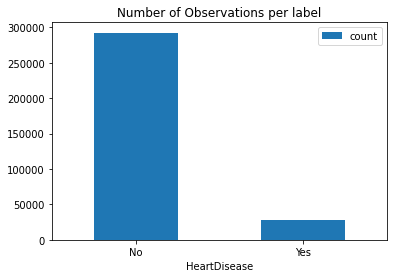

In [ ]:
df.groupBy(label).count().toPandas().plot.bar(x='HeartDisease', rot=0, title='Number of Observations per label')

In [ ]:
train_df, test_df = df.randomSplit([.8,.2])

In [ ]:
from pyspark.ml.feature import (VectorAssembler, OneHotEncoder, StringIndexer)
from pyspark.ml import Pipeline

# Indexers for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+'_indexed') for col in categorical_cols]

# Encoders for categorical columns
encoders = [OneHotEncoder(inputCol=col+'_indexed', outputCol=col+'_encoded') for col in categorical_cols]
 
# Indexer for classification label:
label_indexer = StringIndexer(inputCol=label, outputCol=label+'_indexed')

#assemble all features as vector to be used as input for Spark MLLib
assembler = VectorAssembler(inputCols= [col+'_encoded' for col in categorical_cols] + numerical_cols, outputCol='features')

# Creating data processing pipeline
pipeline = Pipeline(stages= indexers + encoders + [label_indexer, assembler])

In [ ]:
from pyspark.ml.classification import (LogisticRegression, RandomForestClassifier, NaiveBayes)
lr = LogisticRegression(featuresCol='features', labelCol=label+'_indexed')
rfc = RandomForestClassifier(featuresCol='features', labelCol=label+'_indexed', numTrees=100)
nb = NaiveBayes(featuresCol='features', labelCol=label+'_indexed')

In [ ]:
from pyspark.ml.evaluation import (BinaryClassificationEvaluator, MulticlassClassificationEvaluator)

pred_AUC = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol=label+'_indexed')

In [ ]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol=label+'_indexed', predictionCol="prediction", metricName="accuracy")

In [ ]:
import time
start_time1 = time.time()
# creating pipelines with machine learning models
#and fitting the train subset
#also predicting using test subset

#Logistic Regression
pipeline_lr = Pipeline(stages=[pipeline, lr])
lr_fit = pipeline_lr.fit(train_df)
pred_lr = lr_fit.transform(test_df)
AUC_lr = pred_AUC.evaluate(pred_lr)
print('AUC: ', '{:.2f}'.format(AUC_lr*100), '%', sep='')

acc_lr = acc_evaluator.evaluate(pred_lr)
print('\nLogistic Regression accuracy: ', '{:.2f}'.format(acc_lr*100), '%', sep='')
print("--- %s seconds ---" % (time.time() - start_time1))

AUC: 55.00%

Logistic Regression accuracy: 91.60%
--- 63.466209173202515 seconds ---


In [ ]:
start_time2 = time.time()

#Random Forest
pipeline_rfc = Pipeline(stages=[pipeline, rfc])
rfc_fit = pipeline_rfc.fit(train_df)
pred_rfc = rfc_fit.transform(test_df)
AUC_rfc = pred_AUC.evaluate(pred_rfc)
print('AUC: ', '{:.2f}'.format(AUC_rfc*100), '%', sep='')

acc_rfc = acc_evaluator.evaluate(pred_rfc)
print('\nRandom Forest accuracy: ', '{:.2f}'.format(acc_rfc*100), '%', sep='')
print("--- %s seconds ---" % (time.time() - start_time2))

AUC: 50.00%

Random Forest accuracy: 91.44%
--- 93.65992665290833 seconds ---


In [ ]:
start_time3 = time.time()

#Naive Bayes
pipeline_nb = Pipeline(stages=[pipeline, nb])
nb_fit = pipeline_nb.fit(train_df)
pred_nb = nb_fit.transform(test_df)
AUC_nb = pred_AUC.evaluate(pred_nb)
print('AUC: ', '{:.2f}'.format(AUC_nb*100), '%', sep='')

acc_nb = acc_evaluator.evaluate(pred_nb)
print('\nNaive Bayes accuracy: ', '{:.2f}'.format(acc_nb*100), '%', sep='')
print("--- %s seconds ---" % (time.time() - start_time3))

AUC: 60.83%

Naive Bayes accuracy: 83.89%
--- 45.404682874679565 seconds ---
